In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join, exists
import os
%matplotlib inline
from itertools import combinations
from collections import defaultdict 
from src.config import ROOT_DIR, DATA_DIR
from scipy.stats import ttest_ind, chisquare
import tqdm
from copy import deepcopy

Project Directory: /data2/mito_lineage


In [2]:
np.random.seed(42)

In [3]:
outdir = "./output"

In [4]:
if not exists(outdir):
    os.mkdir(outdir)

## Set up parameters for the number of subjects in a batch (day) and number of donors in each multiplex

In [5]:
n_sim=10000
batches=[6,4]
mult=[3,2]

In [6]:
in_f = join(DATA_DIR, "processed", "gilead_chip_profile/CHIPd10", "CHIPd10donor_feature.csv")
donor_meta = pd.read_csv(in_f, index_col=0)
donor_meta

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race
Donor_ID,,,,,,
RB1046,0.546006,0,2870000,53,M,Hispanic
RB1085,0.154719,0,700000,53,F,Hispanic
RB1071,0.141314,0,1600000,54,M,Caucasian
RB1060,0.469024,1,1700000,51,M,Caucasian
RB1065,1.733630,1,1700000,53,F,African_American
RB1002,NaN,1,1300000,50,M,Asian
RB1003,0.014966,0,1090000,64,M,Caucasian
RB1048,0.719311,0,2230000,61,M,Asian
RB1138,0.006915,0,1240000,55,F,African_American


### Sum_VAF is the sum VAF across all CHIP mutations in a donor

## Preprocess and clean df 
make gender and race categorical. 

In [7]:
race_map = {"Hispanic":0, "Caucasian":1, "African_American":2, "Asian":3}
donor_meta["Race"] = donor_meta["Race"].map(race_map)
gend_map ={"M":0,"F":1}
donor_meta["Gender"] = donor_meta["Gender"].map(gend_map)



## A. Plot correlation across features

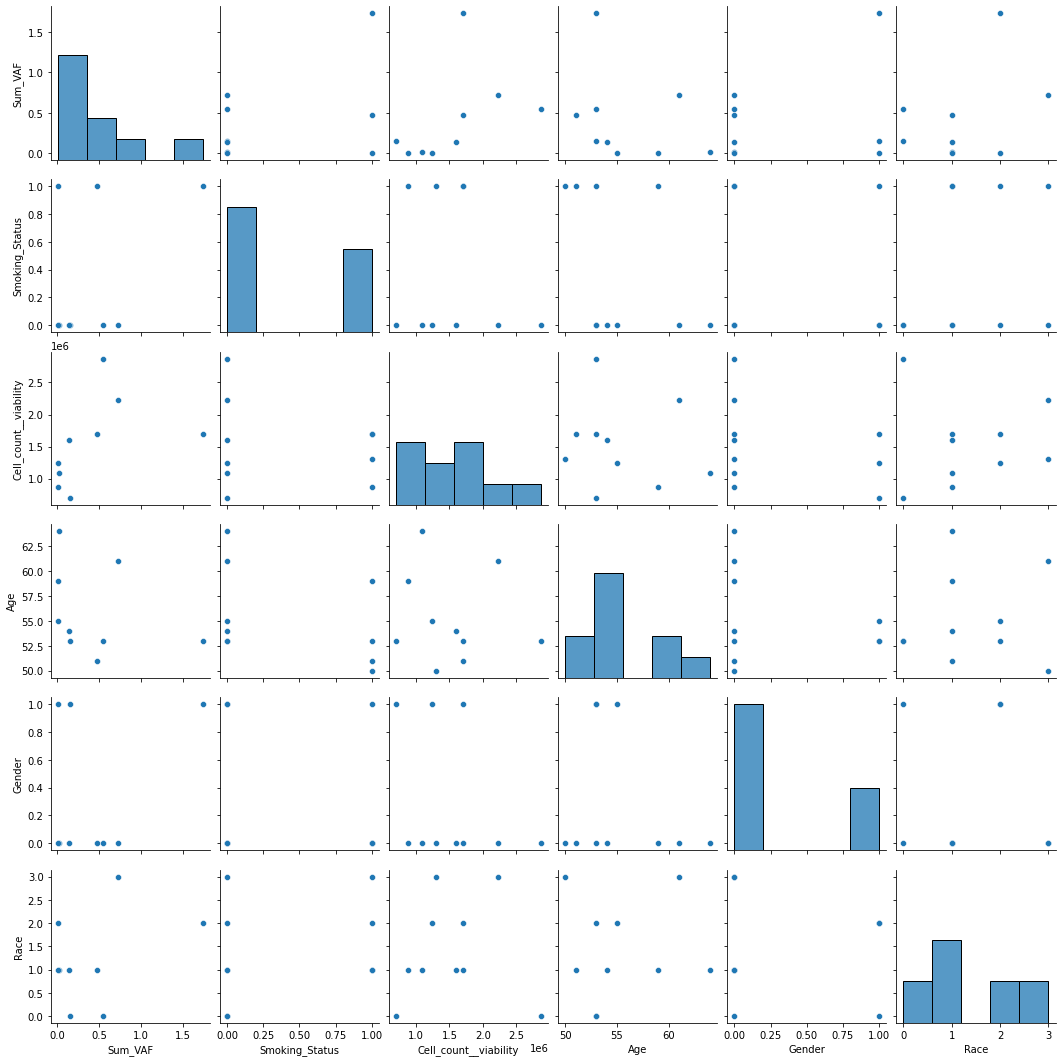

In [8]:
%matplotlib inline
sns.pairplot(donor_meta)

## A. Result: No clear correlation across features, including age-VAF relationship

In [9]:
donor_meta = donor_meta.reset_index()

## B. Sample n_sim times an ordering of donors and store into sim_d

In [10]:
def single_run(sample, batches, mult):
    """ Given a permutation sample & lists of batches and multiplex, will partition donors based on ordering.
    
    """
    #print('sample', sample)
    sim = pd.DataFrame(index=np.arange(len(sample)), columns=["batch","mult"], )
    sim.index.name = "donor"
    for b_ind, b in enumerate(batches):
        curr_b = sample[sum(batches[:b_ind]):sum(batches[:b_ind])+b]
        m_batches = int(np.ceil(b/mult[b_ind]))
        #print("b_ind", b_ind)
        #print('curr_b', curr_b)
        #print('m_batches', m_batches)
        for m_ind in range(m_batches):
            #print("m_ind", m_ind)
            curr_m = curr_b[m_ind*mult[b_ind]:(m_ind*mult[b_ind])+mult[b_ind]]
            #print('curr_m', curr_m)
            sim.loc[curr_m, "batch"] = b_ind
            sim.loc[curr_m, "mult"] = m_ind
            
    return sim

def wrap(n_sim, batches, mult, n_donors=10):
    sim_d={}
    for n in range(n_sim):
        sim_d[n] = single_run(np.random.permutation(n_donors), batches, mult)
    return pd.concat(sim_d).reset_index().rename({"level_0":"sim"}, axis=1)

sim_d = wrap(n_sim, batches=[6,4], mult=[3,2])
sim_d

,sim,donor,batch,mult
0,0,0,0,1
1,0,1,0,0
2,0,2,0,1
3,0,3,1,1
4,0,4,1,0
...,...,...,...,...
99995,9999,5,0,1
99996,9999,6,0,0
99997,9999,7,0,0
99998,9999,8,0,0


## C. For each sampled plate layout, calculate the t-test and/or Chi-square p-value between the two different batches (higher value means samples are more evenly mixed)
(If >2 plates, will need to do Anova instead)

In [11]:
sim_ttest = pd.DataFrame(index=np.arange(n_sim),columns=donor_meta.drop("Donor_ID",axis=1).columns)
for s, df in sim_d.groupby("sim"):
    curr_sol = pd.concat((df.set_index("donor"),donor_meta.reset_index()), axis=1)
    for f in donor_meta.drop("Donor_ID",axis=1).columns: #sim_ttest.append(ttest_ind(df[df["batch"]==0], df[df["batch"]==1]))
        try:
            sim_ttest.loc[s, f]=ttest_ind(curr_sol[curr_sol["batch"]==0][f].fillna(0), curr_sol[curr_sol["batch"]==1][f].fillna(0))[1]
        except TypeError:
            sim_ttest.loc[s, f]=chisquare(curr_sol[curr_sol["batch"]==0][f], curr_sol[curr_sol["batch"]==1][f])[1]

## D. Plot the distributions of the p-value results across each feature 

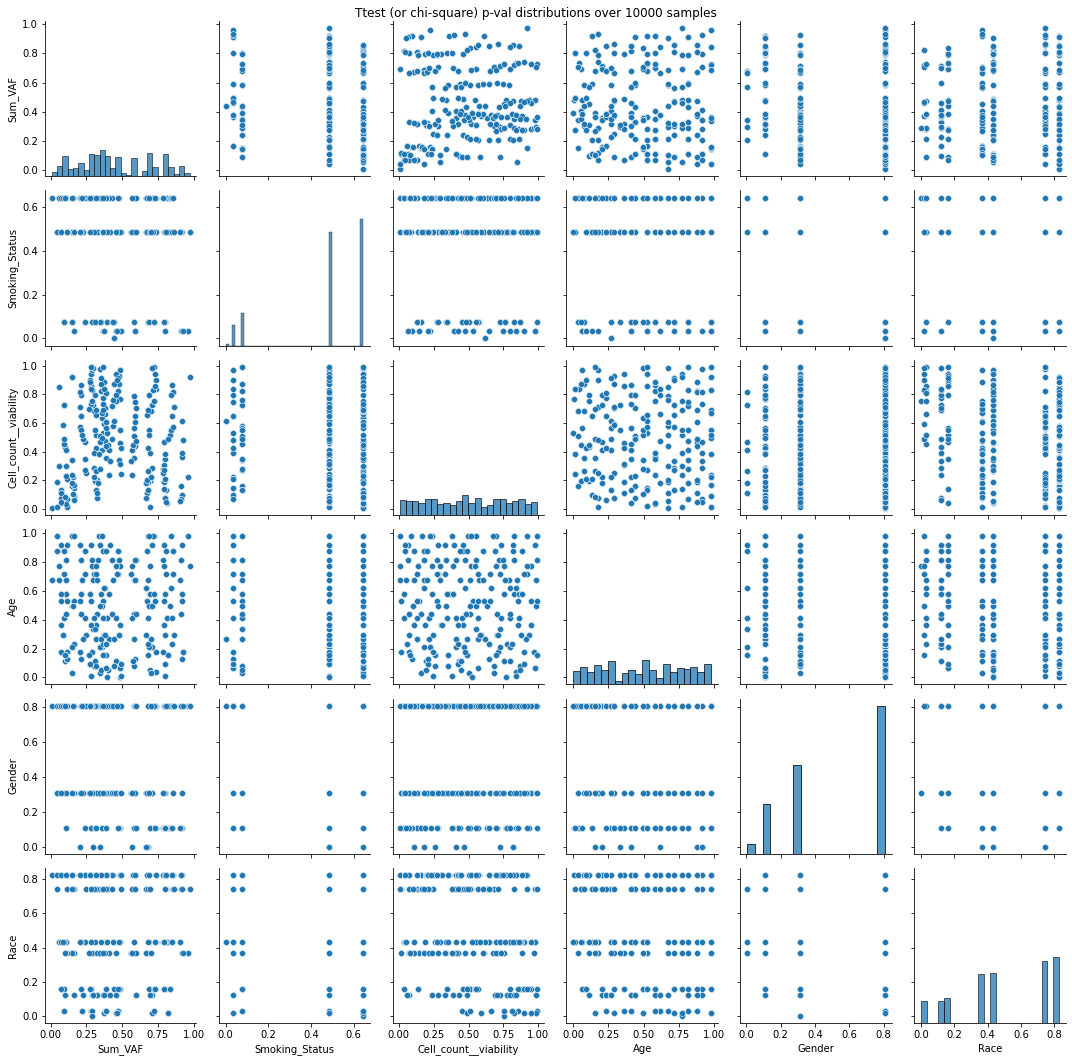

In [12]:
sns.pairplot(sim_ttest)
plt.suptitle("Ttest (or chi-square) p-val distributions over 10000 samples")
plt.tight_layout()

# E. Take best score and plot the features and layout

In [13]:
def plot_distribution(features_df, feat_cols, levels=1, out_f=None):
    """ Plots feature distribution across different levels of a layout (discrete subgroups)
    
    solution: DF where columns are g1, g2 and index is donor id, representing the hierarchical plate layout. 
    
              Example: row 1: "d1", 1, 2, means that donor 1 is in group 1 in the large group, and group 2 in the subgroup
    features_df: DF where index is donor id and columns are features
    
    levels: How many level to look at
    out_f: Where to plot the figure. Default=None
    feature_priority: If there is an order in which to plot the features based on the priority
    """

    for curr_feat in features_df.drop(set(features_df.columns)-set(feat_cols), axis=1).columns:
        #print(curr_feat)
        sns.catplot(data=features_df, kind="strip", y=curr_feat, col="batch")
        if out_f is not None:
            plt.savefig(f"{out_f}_{curr_feat}.png")

    # batch level group:
    #sns.catplot(features_df, hue = "batch")
    
    return


In [14]:
best_sim = sim_ttest.sort_values(["Sum_VAF", "Cell_count__viability"], ascending=False).iloc[0].name
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

61


,sim,donor,batch,mult
610,61,0,0,1
611,61,1,1,1
612,61,2,1,0
613,61,3,1,0
614,61,4,0,1
615,61,5,0,1
616,61,6,0,0
617,61,7,1,1
618,61,8,0,0
619,61,9,0,0


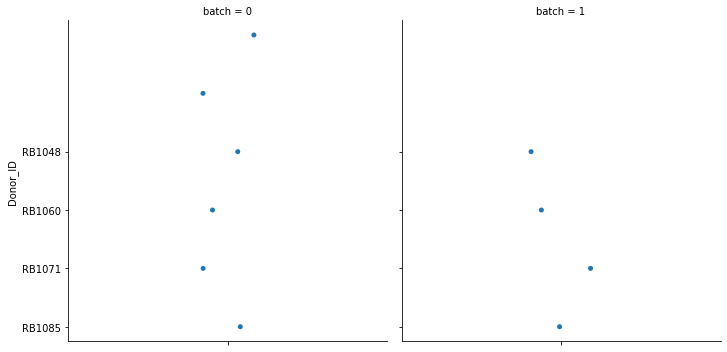

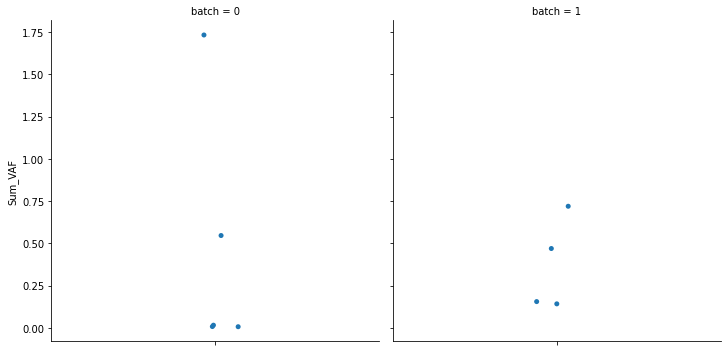

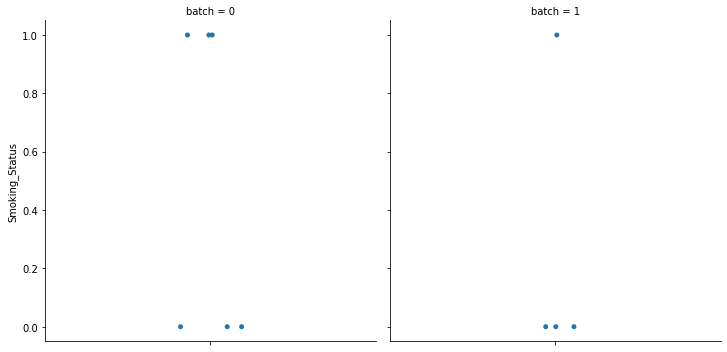

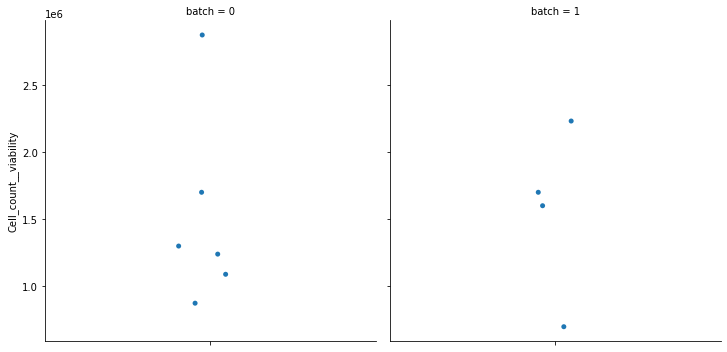

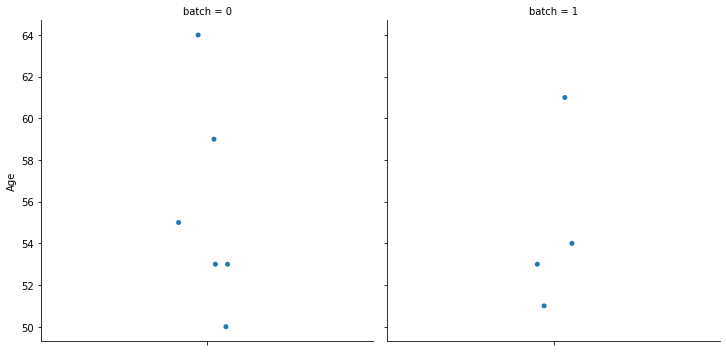

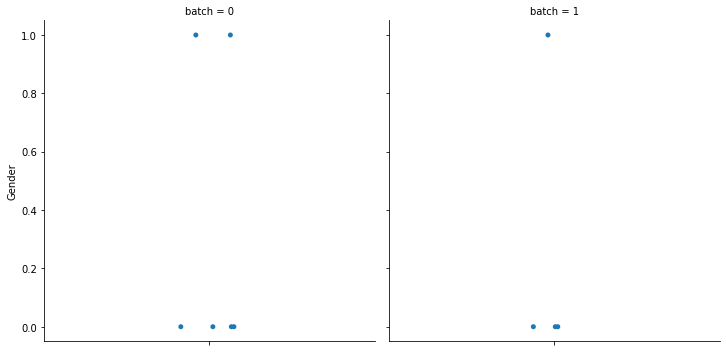

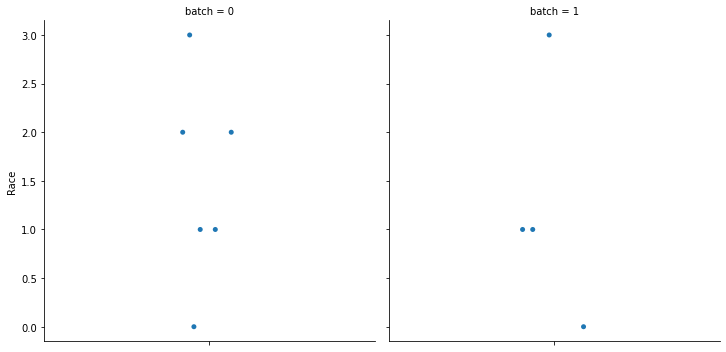

In [15]:
plot_distribution(pd.concat((best_df.set_index("donor"), donor_meta), axis=1), donor_meta.columns,)

<AxesSubplot:xlabel='mult', ylabel='Sum_VAF'>

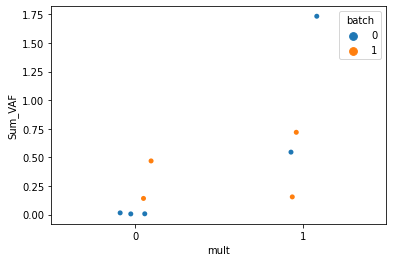

In [16]:
sns.stripplot(data=pd.concat((best_df.set_index("donor"), donor_meta),axis=1), y="Sum_VAF", x="mult", hue = "batch")

# F. Do the same as before, but now also calculate for multiplex groupings.
Take the mean of the within-multiplex within-batch p-values

In [17]:
sim_ttest_mult = pd.DataFrame(index=np.arange(n_sim),columns=donor_meta.drop("Donor_ID",axis=1).columns)
for s, df in sim_d.groupby("sim"):
    all_mult = defaultdict(list)
    for b, df2 in df.groupby(["batch"]):  
#         print('df2')
#         print(df2)
        df2 = pd.concat((df2.set_index("donor"),donor_meta.reset_index()), axis=1)
        for f in donor_meta.drop("Donor_ID",axis=1).columns: #sim_ttest_mult.append(ttest_ind(df[df["batch"]==0], df[df["batch"]==1]))
            try:
                all_mult[f].append(ttest_ind(df2[df2["mult"]==0][f].fillna(0), df2[df2["mult"]==1][f].fillna(0))[1])
                #sim_ttest_mult.loc[s, f]=ttest_ind(df2[df2["batch"]==0][f].fillna(0), df2[df2["batch"]==1][f].fillna(0))[1]
            except TypeError:
                #sim_ttest_mult.loc[s, f]=chisquare(df2[df2["batch"]==0][f], df2[df2["batch"]==1][f])[1]
                all_mult[f].append(chisquare(df2[df2["mult"]==0][f].fillna(0), df2[df2["mult"]==1][f].fillna(0))[1])
    for f in donor_meta.drop("Donor_ID",axis=1).columns:
        sim_ttest_mult.loc[s, f]= np.mean(np.array(all_mult[f]))
sim_ttest_mult.columns = [x+"_mult" for x in sim_ttest_mult.columns]

In [18]:
tests_cat = pd.concat((sim_ttest,sim_ttest_mult),axis=1)
tests_cat.head(5)

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race,Sum_VAF_mult,Smoking_Status_mult,Cell_count__viability_mult,Age_mult,Gender_mult,Race_mult
0,0.432603,0.0766984,0.48465,0.44287,0.806661,0.741046,0.317839,0.398275,0.451355,0.584368,0.269383,0.612566
1,0.482444,0.486042,0.765798,0.00599084,0.111434,0.825978,0.462259,0.211325,0.880035,0.482531,NaN,0.313878
2,0.0564359,0.645376,0.849985,0.676268,0.31216,0.825978,0.472122,1,0.346901,0.722174,0.18695,0.334451
3,0.442816,0,0.616374,0.267893,0.806661,0.432919,0.522979,NaN,0.276453,0.413396,0.711325,0.733066
4,0.319564,0.645376,0.42665,0.364607,0.111434,0.366978,0.648951,0.558058,0.479935,0.535166,NaN,NaN


5125
Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


<Figure size 432x288 with 0 Axes>

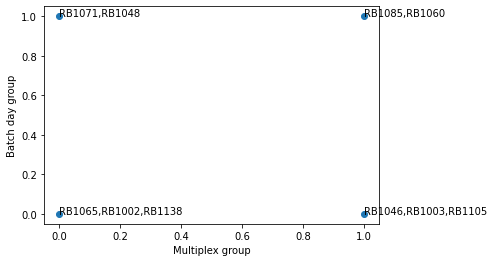

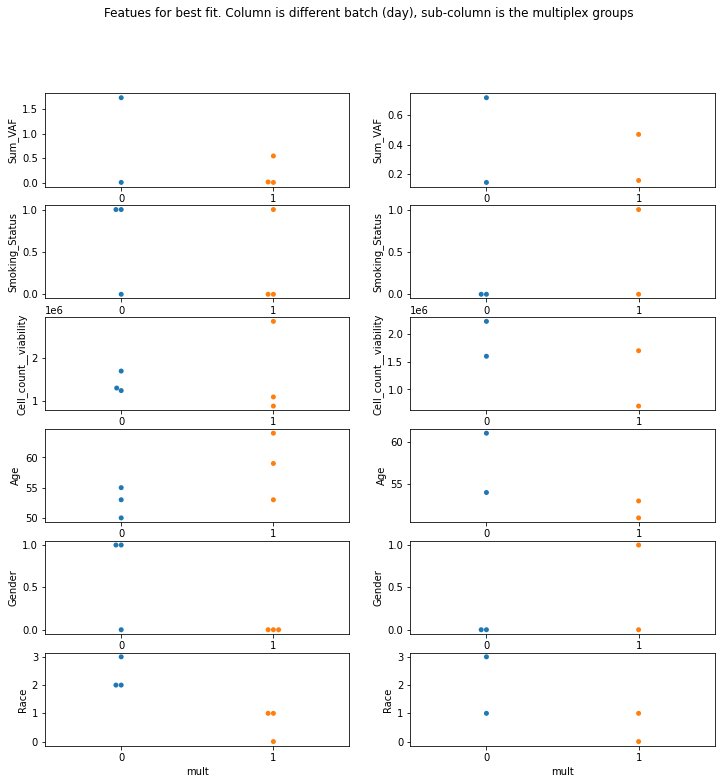

In [19]:
best_sim = tests_cat.sort_values(["Sum_VAF", "Sum_VAF_mult",
                                  "Cell_count__viability", "Smoking_Status", 
                                 "Cell_count__viability_mult", "Gender", "Gender_mult", 
                                 "Age", "Age_mult"], ascending=False).iloc[0].name
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
y = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby(["mult", "batch"]):
    x.append(ind[0])
    y.append(ind[1])
    txt.append(",".join(donor_meta.loc[val["donor"], "Donor_ID"].values))

    
fig, ax = plt.subplots()
ax.scatter(x,y)
for i, t in enumerate(txt):
    ax.annotate(t, (x[i], y[i]))

plt.xlabel("Multiplex group")
plt.ylabel("Batch day group")

count=0
n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))

best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    for b in range(n_batch):        
        sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
                     ax=ax[count, b])
        plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1


# Aggregate scoring with weighting

5125
Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


<Figure size 432x288 with 0 Axes>

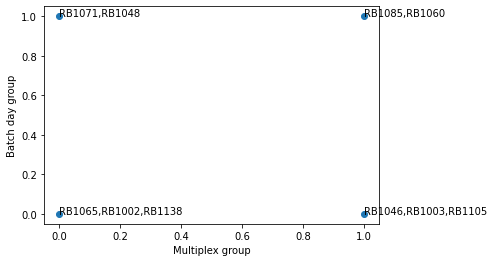

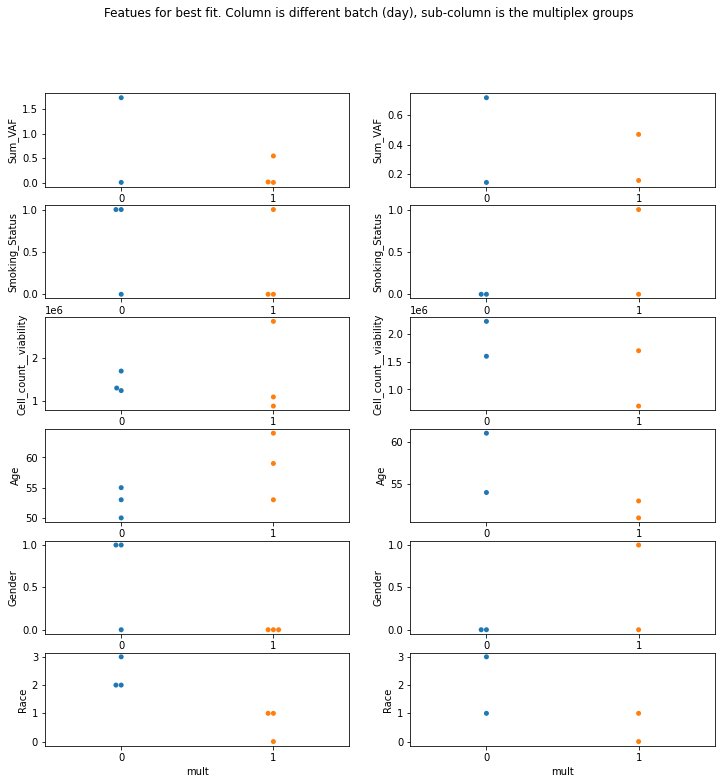

In [20]:
best_sim = tests_cat.sort_values(["Sum_VAF", "Sum_VAF_mult",
                                  "Cell_count__viability", "Smoking_Status", 
                                 "Cell_count__viability_mult", "Gender", "Gender_mult", 
                                 "Age", "Age_mult"], ascending=False).iloc[0].name
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
y = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby(["mult", "batch"]):
    x.append(ind[0])
    y.append(ind[1])
    txt.append(",".join(donor_meta.loc[val["donor"], "Donor_ID"].values))

    
fig, ax = plt.subplots()
ax.scatter(x,y)
for i, t in enumerate(txt):
    ax.annotate(t, (x[i], y[i]))

plt.xlabel("Multiplex group")
plt.ylabel("Batch day group")

count=0
n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))

best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    for b in range(n_batch):        
        sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
                     ax=ax[count, b])
        plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1


In [21]:
weights = {"Sum_VAF":2, "Sum_VAF_mult":2, "Cell_count__viability":1.8, "Cell_count__viability_mult":1.8,
           "Smoking_Status":1.5, "Smoking_Status_mult":1.5,
          "Age":1, "Age_mult":1, "Gender":1, "Gender_mult":1}

scores = tests_cat.apply(lambda x: sum([x[w]*weights[w] if (not np.isnan(x[w])) else 0 for w in weights]), axis=1)

tests_cat.head()

# best_df

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race,Sum_VAF_mult,Smoking_Status_mult,Cell_count__viability_mult,Age_mult,Gender_mult,Race_mult
0,0.432603,0.0766984,0.48465,0.44287,0.806661,0.741046,0.317839,0.398275,0.451355,0.584368,0.269383,0.612566
1,0.482444,0.486042,0.765798,0.00599084,0.111434,0.825978,0.462259,0.211325,0.880035,0.482531,NaN,0.313878
2,0.0564359,0.645376,0.849985,0.676268,0.31216,0.825978,0.472122,1,0.346901,0.722174,0.18695,0.334451
3,0.442816,0,0.616374,0.267893,0.806661,0.432919,0.522979,NaN,0.276453,0.413396,0.711325,0.733066
4,0.319564,0.645376,0.42665,0.364607,0.111434,0.366978,0.648951,0.558058,0.479935,0.535166,NaN,NaN


3722
Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


<Figure size 432x288 with 0 Axes>

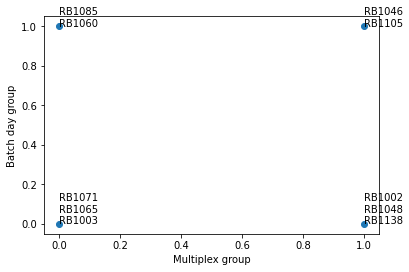

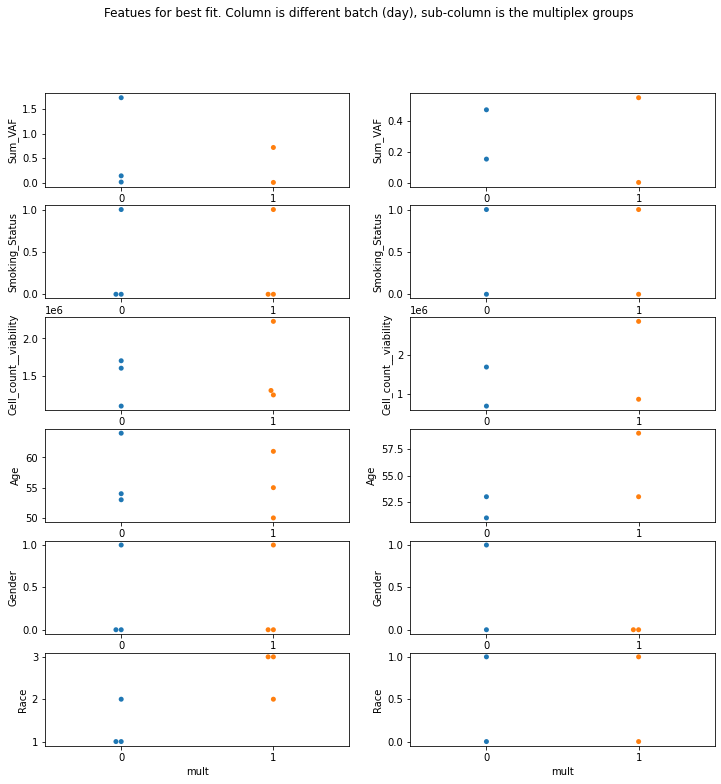

In [22]:
best_sim = scores.sort_values(ascending=False).index[0]
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
y = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby(["mult", "batch"]):
    x.append(ind[0])
    y.append(ind[1])
    txt.append("\n".join(donor_meta.loc[val["donor"], "Donor_ID"].values))

    
fig, ax = plt.subplots()
ax.scatter(x,y)
for i, t in enumerate(txt):
    ax.annotate(t, (x[i], y[i]))

plt.xlabel("Multiplex group")
plt.ylabel("Batch day group")
plt.savefig(join(outdir, "best_experiment_layout.pdf"), bbox_inches='tight')

count=0
n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))
best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    for b in range(n_batch):        
        sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
                     ax=ax[count, b])
        plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1

plt.savefig(join(outdir, "best_experiment_features.pdf"))


## Weight multiplex by half

In [23]:
weights = {"Sum_VAF":2, "Sum_VAF_mult":2/2, "Cell_count__viability":1.8, "Cell_count__viability_mult":1.8/2,
           "Smoking_Status":1.5, "Smoking_Status_mult":1.5/2,
          "Age":1, "Age_mult":1/2, "Gender":1, "Gender_mult":1/2}

scores = tests_cat.apply(lambda x: sum([x[w]*weights[w] if (not np.isnan(x[w])) else 0 for w in weights]), axis=1)

tests_cat.head()

# best_df

,Sum_VAF,Smoking_Status,Cell_count__viability,Age,Gender,Race,Sum_VAF_mult,Smoking_Status_mult,Cell_count__viability_mult,Age_mult,Gender_mult,Race_mult
0,0.432603,0.0766984,0.48465,0.44287,0.806661,0.741046,0.317839,0.398275,0.451355,0.584368,0.269383,0.612566
1,0.482444,0.486042,0.765798,0.00599084,0.111434,0.825978,0.462259,0.211325,0.880035,0.482531,NaN,0.313878
2,0.0564359,0.645376,0.849985,0.676268,0.31216,0.825978,0.472122,1,0.346901,0.722174,0.18695,0.334451
3,0.442816,0,0.616374,0.267893,0.806661,0.432919,0.522979,NaN,0.276453,0.413396,0.711325,0.733066
4,0.319564,0.645376,0.42665,0.364607,0.111434,0.366978,0.648951,0.558058,0.479935,0.535166,NaN,NaN


9453
Sum_VAF
Smoking_Status
Cell_count__viability
Age
Gender
Race


<Figure size 432x288 with 0 Axes>

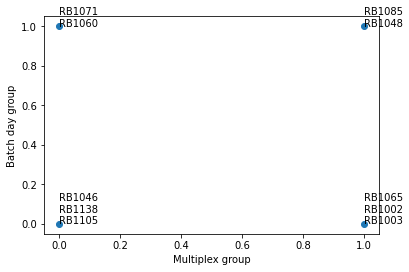

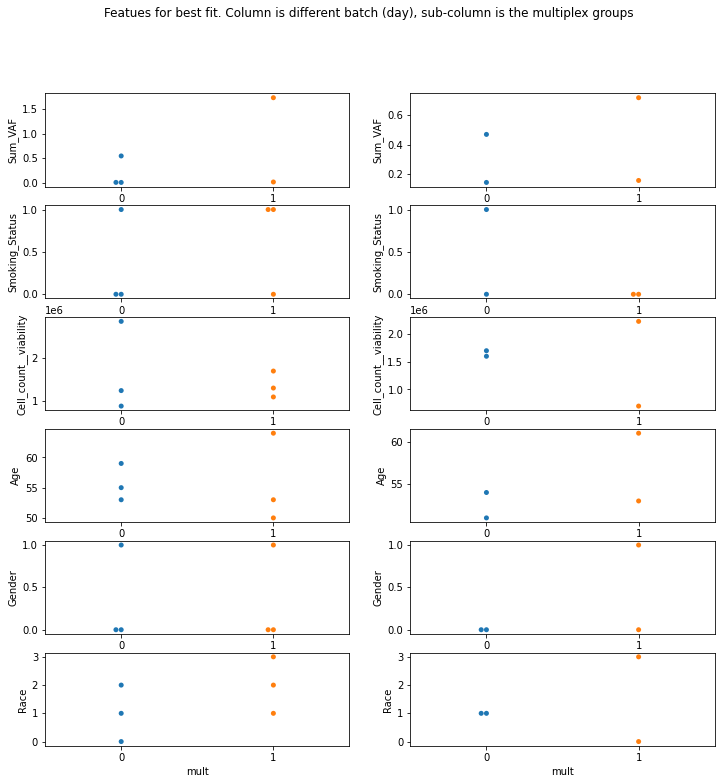

In [24]:
best_sim = scores.sort_values(ascending=False).index[0]
print(best_sim)
best_df = sim_d.loc[sim_d["sim"]==best_sim]
best_df

# Best fit layout

x = []
y = []
txt = []
f = plt.figure()
for ind, val in best_df.groupby(["mult", "batch"]):
    x.append(ind[0])
    y.append(ind[1])
    txt.append("\n".join(donor_meta.loc[val["donor"], "Donor_ID"].values))

    
fig, ax = plt.subplots()
ax.scatter(x,y)
for i, t in enumerate(txt):
    ax.annotate(t, (x[i], y[i]))

plt.xlabel("Multiplex group")
plt.ylabel("Batch day group")
plt.savefig(join(outdir, "best_experiment_layout.multLess.pdf"), bbox_inches='tight')

count=0
n_batch = len(best_df["batch"].unique())
f, ax = plt.subplots(nrows=len(donor_meta.columns)-1, ncols=n_batch, figsize=(12,12))
best_in = pd.concat((best_df.set_index("donor"), donor_meta),axis=1)
for feat in donor_meta.drop("Donor_ID",axis=1).columns:
    print(feat)
    for b in range(n_batch):        
        sns.swarmplot(data=best_in[best_in["batch"]==b], y=feat, x = "mult",
                     ax=ax[count, b])
        plt.suptitle("Featues for best fit. Column is different batch (day), sub-column is the multiplex groups")
    count+=1

plt.savefig(join(outdir, "best_experiment_features.multLess.pdf"))
